In [29]:
import random
import time
import math
import matplotlib.pyplot as plt

%matplotlib inline


In [30]:
def build_test_graph_adj():

    G = {}

    def add_edge(u, v, w):
        G.setdefault(u, {})[v] = w
        G.setdefault(v, {})[u] = w

    edges = [
        (1, 2, 3),
        (1, 3, 1),
        (2, 3, 3),
        (2, 4, 1),
        (3, 4, 3),
        (3, 5, 2),
        (4, 5, 4),
    ]
    for u, v, w in edges:
        add_edge(u, v, w)
    return G

G = build_test_graph_adj()
print("Adjacency dict:", G)


Adjacency dict: {1: {2: 3, 3: 1}, 2: {1: 3, 3: 3, 4: 1}, 3: {1: 1, 2: 3, 4: 3, 5: 2}, 4: {2: 1, 3: 3, 5: 4}, 5: {3: 2, 4: 4}}


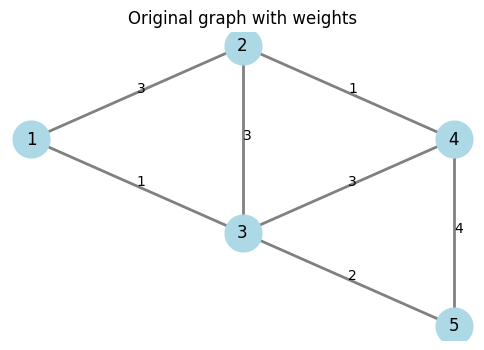

In [31]:
# Fixed positions for nodes 1..5 (manual layout)
fixed_pos = {
    1: (-1.0,  0.5),
    2: ( 0.0,  1.0),
    3: ( 0.0,  0.0),
    4: ( 1.0,  0.5),
    5: ( 1.0, -0.5),
}

def draw_graph_basic(G, pos, title="Graph", node_colors=None, highlight_edges=None):
    """
    Draw an undirected weighted graph G using only matplotlib.
    - G: dict-of-dict adjacency
    - pos: dict node -> (x, y)
    - node_colors: dict node -> color
    - highlight_edges: set of (u, v) to draw in red
    """
    plt.figure(figsize=(6, 4))

    # Draw edges
    seen = set()
    for u in G:
        for v, w in G[u].items():
            if (v, u) in seen:
                continue
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            color = "gray"
            if highlight_edges and ((u, v) in highlight_edges or (v, u) in highlight_edges):
                color = "red"
            plt.plot([x1, x2], [y1, y2], color=color, linewidth=2)
            mx, my = (x1 + x2) / 2, (y1 + y2) / 2
            plt.text(mx, my, str(w), color="black", fontsize=10)
            seen.add((u, v))

    # Draw nodes
    for u, (x, y) in pos.items():
        c = node_colors.get(u, "lightblue") if node_colors else "lightblue"
        plt.scatter([x], [y], s=700, color=c, zorder=3)
        plt.text(x, y, str(u), ha="center", va="center", fontsize=12, color="black")

    plt.title(title)
    plt.axis("off")
    plt.show()

# Show original graph
draw_graph_basic(G, fixed_pos, title="Original graph with weights")


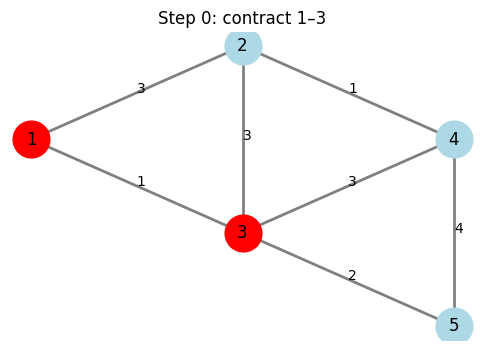

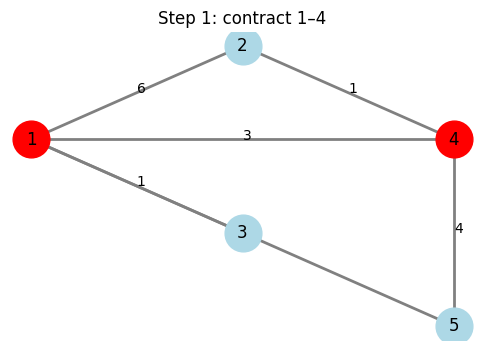

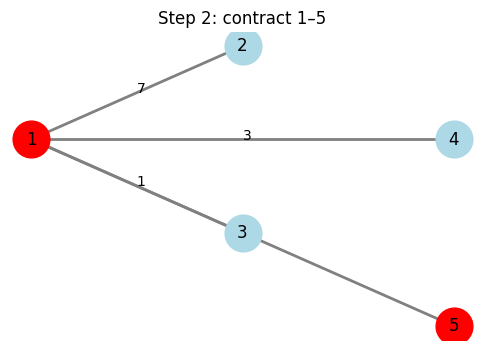

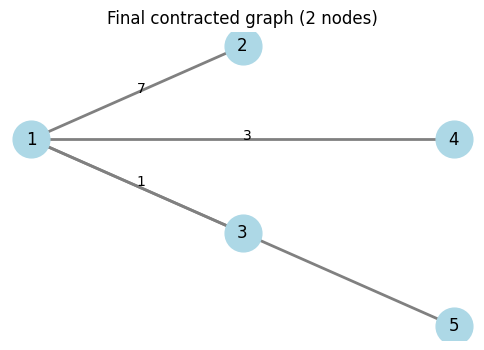

Cut value: 7
Partition S: {1, 3, 4, 5}
Partition T: {2}


In [32]:
def karger_min_cut_with_visualization_adj(G_input, pos, show_steps=True):
    """
    Karger's randomized min-cut on an adjacency-dict graph
    with simple matplotlib visualization.
    """
    # Deep copy of adjacency
    G = {u: dict(neighs) for u, neighs in G_input.items()}
    # Track which original nodes each supernode represents
    supernodes = {u: {u} for u in G}

    step = 0
    while len(G) > 2:
        # Build edge list and weights
        edges = []
        weights = []
        for u in G:
            for v, w in G[u].items():
                if u < v:
                    edges.append((u, v))
                    weights.append(w)

        # Randomly pick an edge to contract (weighted by edge weight)
        (u, v) = random.choices(edges, weights=weights, k=1)[0]

        if show_steps:
            colors = {node: "lightblue" for node in G}
            colors[u] = colors[v] = "red"
            draw_graph_basic(G, pos, title=f"Step {step}: contract {u}–{v}",
                             node_colors=colors)

        # Merge v into u
        supernodes[u] |= supernodes[v]
        del supernodes[v]

        # Rewire neighbors of v to u
        neighbors_v = list(G[v].items())
        for nbr, w in neighbors_v:
            if nbr == u:
                continue
            if v in G[nbr]:
                del G[nbr][v]
            if nbr in G[u]:
                G[u][nbr] += w
                G[nbr][u] += w
            else:
                G[u][nbr] = w
                G[nbr][u] = w

        del G[v]
        if u in G[u]:
            del G[u][u]

        step += 1

    if show_steps:
        draw_graph_basic(G, pos, title=f"Final contracted graph ({len(G)} nodes)")

    # Compute cut value and partition
    nodes = list(G.keys())
    a, b = nodes[0], nodes[1]
    cut_value = G[a].get(b, 0)
    S = supernodes[a]
    T = supernodes[b]
    return cut_value, (S, T)

# Run Karger once and see the steps
best_val, (S, T) = karger_min_cut_with_visualization_adj(G, fixed_pos, show_steps=True)
print("Cut value:", best_val)
print("Partition S:", S)
print("Partition T:", T)


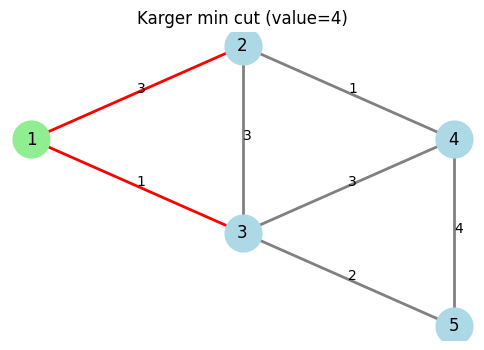

In [28]:
def draw_cut_basic(G_input, partition, pos, title="Min cut"):
    """
    Draw final cut: nodes in S green, nodes in T blue, cut edges red.
    """
    G = G_input
    S, T = map(set, partition)
    
    cut_edges = set()
    seen = set()
    for u in G:
        for v, w in G[u].items():
            if (v, u) in seen:
                continue
            e = (u, v)
            if (u in S and v in T) or (u in T and v in S):
                cut_edges.add(e)
            seen.add(e)
    
    node_colors = {u: ("lightgreen" if u in S else "lightblue") for u in G}
    draw_graph_basic(G, pos, title=title, node_colors=node_colors,
                     highlight_edges=cut_edges)

draw_cut_basic(G, (S, T), fixed_pos, title=f"Karger min cut (value={best_val})")
